In [ ]:
import os
import gym
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import namedtuple, deque
from ale_py import ALEInterface
import wandb
import imageio
import matplotlib.pyplot as plt
import warnings
import logging
from utils_AC import *



In [1]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter out INFO, 2 = filter out WARNING, 3 = filter out ERROR
tf.get_logger().setLevel('ERROR')

warnings.filterwarnings('ignore')


gym_logger = logging.getLogger('gym')
gym_logger.setLevel(logging.ERROR)

In [15]:
#API KEY: 73c9a156b91f3e0c01c3d5f332d23bfc66f4cdbf

In [2]:
import wandb
wandb.init(project="ActorCritic", entity = "rl_proj")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: roysgc (rl_proj). Use `wandb login --relogin` to force relogin


In [3]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

ale = ALEInterface()



config = Config()
best_reward = 0

#env = gym.make("Assault-v4", render_mode="rgb_array")
env = gym.make("Assault-v4") 
n_actions = env.action_space.n

actor_model = Actor(n_actions)
print("Number of actions:", n_actions)
actor_model.build(input_shape=(None, 210, 160, 3))  # Build the model with the input shape
actor_model.summary()
dummy_input = np.random.random((1, 210, 160, 3))
actor_model(dummy_input)

critic_model = Critic()
critic_model.build(input_shape=(None, 210, 160, 3))  # Build the model with the input shape
critic_model.summary()

# Run a dummy input through the model to finalize its construction
dummy_input = np.random.random((1, 210, 160, 3))
critic_model(dummy_input)



lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
actor_optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
critic_optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

memory = ReplayMemory(config.MEMORY_SIZE)

episode_rewards = []
epsilon = config.EPSILON_START

for episode in range(config.EPISODES):
    #state, info = env.reset()
    #state = state / 255.0
    state = env.reset() / 255.0
    done = False
    episode_reward = 0
    steps = 0
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}
    frames = []
    max_steps = 100

    while not done and info.get("ale.lives") > 0: #steps < config.MAX_STEPS_PER_EPISODE and info.get("lives") >= 0:
        #action = take_action(state, epsilon)

        #step_result = env.step(action)
        #next_state, reward, done, _, info = step_result[:5]
        #next_state = next_state / 255.0

        action = take_action(state, epsilon, env, actor_model, n_actions)
        
        step_result = env.step(action)
        
        next_state, reward, done, info = step_result

        next_state = next_state / 255.0

        memory.push(state, action, next_state, reward, done)
        optimize_model(memory, config, critic_model , critic_optimizer, actor_model, actor_optimizer, n_actions)

        frame = env.render(mode='rgb_array')
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("step: ", steps, "action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))

        steps += 1

    print(f"Episode: {episode+1}, Reward: {episode_reward}, Epsilon: {epsilon}")

    if episode_reward > best_reward:
        best_reward = episode_reward

        #CAMBIAR PATH a la carpeta AC
        actor_model.save("./best_actor_model", save_format="tf")
        
        #CAMBIAR PATH a la carpeta AC
        critic_model.save("./best_critic_model", save_format="tf")
        print("New best model saved with reward:", episode_reward)

        gif_path = f"./episode_{episode+1}_reward_{episode_reward}.gif"
        
        imageio.mimsave(gif_path, frames, fps=30)

    episode_rewards.append(episode_reward)

    epsilon = max((epsilon * config.EPSILON_DECAY_RATE), config.EPSILON_END)

    # Log episode metrics and GIF to wandb
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon": epsilon, "episode_gif": wandb.Video(gif_path, fps=4, format="gif")})

env.close()



Number of actions: 7
Model: "actor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  6176      
                                                                 
 conv2d_1 (Conv2D)           multiple                  32832     
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           multiple                  36928     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  11534848  
                                        

New best model saved with reward: 63.0
1/1 [==============================] - 0s 182ms/step
Action probabilities: [[0.1422158  0.1355353  0.14893652 0.14380349 0.14022204 0.1400763
  0.14921048]]


KeyboardInterrupt: 

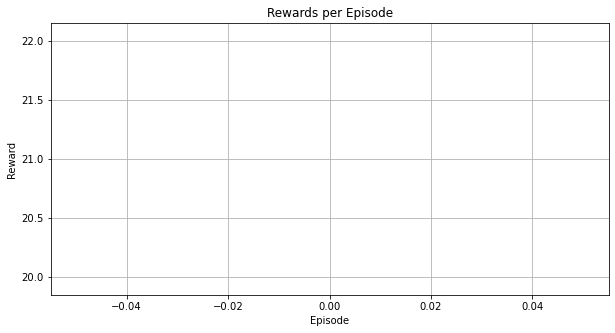

In [11]:
plot_rewards(episode_rewards)

In [13]:
#TEST THE SAVED MODEL
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

#CAMBIAR PATH a la carpeta AC
actor_model = keras.models.load_model("./best_actor_model")

#CAMBIAR PATH a la carpeta AC
critic_model = keras.models.load_model("./best_critic_model")

env = gym.make("Assault-v4")
n_actions = env.action_space.n

rewards_per_episode = []
best_reward = 0

for episode in range(500):
    state= env.reset()
    state = state / 255.0 
    done = False
    episode_reward = 0
    frames = []
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}

    while not done:
        action = take_action_test(state, actor_model, n_actions)
        next_state, reward, done, info = env.step(action)
        next_state = next_state / 255.0  # Normaliza los valores de píxeles

        frame = env.render(mode = "rgb_array")
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))

    rewards_per_episode.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward}")

    if episode_reward > best_reward:
        best_reward = episode_reward  
        
        gif_path = f"./test_episode_{episode+1}_reward_{episode_reward}.gif"
        imageio.mimsave(gif_path, frames, fps=30)  

    # Log episode metrics and GIF to wandb
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon": epsilon, "episode_gif": wandb.Video(gif_path, fps=4, format="gif")})


env.close()

# Grafica las recompensas por episodio
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

1/1 [==============================] - 0s 28ms/step
action:  1  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 24ms/step
action:  3  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 23ms/step
action:  1  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 24ms/step
action:  5  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 26ms/step
action:  3  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 23ms/step


KeyboardInterrupt: 